In [1]:
!pip install numpy==1.23.5

/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Episode: 0, Reward: -200.0, Epsilon: 0.50
Episode: 1, Reward: -200.0, Epsilon: 0.18
Episode: 2, Reward: -200.0, Epsilon: 0.07
Episode: 3, Reward: -200.0, Epsilon: 0.02
Episode: 4, Reward: -200.0, Epsilon: 0.01
Episode: 5, Reward: -200.0, Epsilon: 0.01
Episode: 6, Reward: -200.0, Epsilon: 0.01
Episode: 7, Reward: -200.0, Epsilon: 0.01
Episode: 8, Reward: -200.0, Epsilon: 0.01
Episode: 9, Reward: -200.0, Epsilon: 0.01
Episode: 10, Reward: -200.0, Epsilon: 0.01
Episode: 11, Reward: -200.0, Epsilon: 0.01
Episode: 12, Reward: -200.0, Epsilon: 0.01
Episode: 13, Reward: -200.0, Epsilon: 0.01
Episode: 14, Reward: -200.0, Epsilon: 0.01
Episode: 15, Reward: -200.0, Epsilon: 0.01
Episode: 16, Reward: -200.0, Epsilon: 0.01
Episode: 17, Reward: -200.0, Epsilon: 0.01
Episode: 18, Reward: -200.0, Epsilon: 0.01
Episode: 19, Reward: -200.0, Epsilon: 0.01
Episode: 20, Reward: -200.0, Epsilon: 0.01
Episode: 21, Reward: -200.0, Epsilon: 0.01
Episode: 22, Reward: -200.0, Epsilon: 0.01
Episode: 23, Reward: 

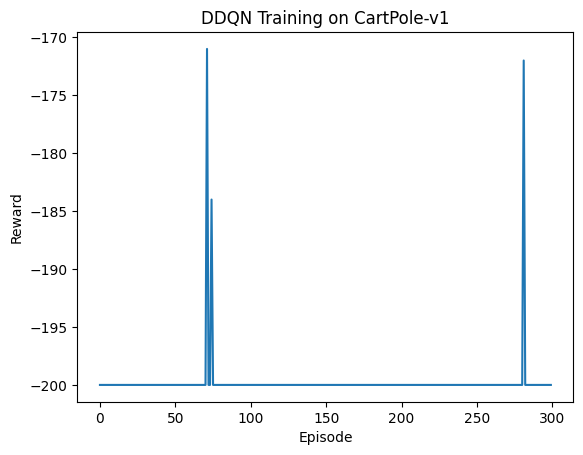

In [3]:
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
import matplotlib.pyplot as plt

# Среда
env = gym.make('MountainCar-v0')
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

# Hyperparameters
LR = 0.001
GAMMA = 0.99
BATCH_SIZE = 64
MEMORY_SIZE = 10000
UPDATE_TARGET_EVERY = 10
EPSILON_START = 1.0
EPSILON_END = 0.01
EPSILON_DECAY = 0.995

# Нейросеть для Q-функции
class DQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# Агент DDQN
class DDQNAgent:
    def __init__(self):
        self.q_net = DQN(state_dim, action_dim)
        self.target_net = DQN(state_dim, action_dim)
        self.target_net.load_state_dict(self.q_net.state_dict())
        self.optimizer = optim.Adam(self.q_net.parameters(), lr=LR)
        self.memory = deque(maxlen=MEMORY_SIZE)
        self.epsilon = EPSILON_START
        self.update_target_counter = 0

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if random.random() < self.epsilon:
            return env.action_space.sample()
        state = torch.FloatTensor(state)
        q_values = self.q_net(state)
        return torch.argmax(q_values).item()

    def train(self):
        if len(self.memory) < BATCH_SIZE:
            return

        batch = random.sample(self.memory, BATCH_SIZE)
        states = torch.FloatTensor([x[0] for x in batch])
        actions = torch.LongTensor([x[1] for x in batch])
        rewards = torch.FloatTensor([x[2] for x in batch])
        next_states = torch.FloatTensor([x[3] for x in batch])
        dones = torch.FloatTensor([x[4] for x in batch])

        # DDQN: выбираем действия основной сетью, оцениваем целевой
        current_q = self.q_net(states).gather(1, actions.unsqueeze(1))
        next_actions = torch.argmax(self.q_net(next_states), dim=1)
        next_q = self.target_net(next_states).gather(1, next_actions.unsqueeze(1))
        target_q = rewards + (1 - dones) * GAMMA * next_q

        loss = nn.MSELoss()(current_q, target_q.detach())
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Decay epsilon
        self.epsilon = max(EPSILON_END, self.epsilon * EPSILON_DECAY)

        # Обновляем целевую сеть
        self.update_target_counter += 1
        if self.update_target_counter % UPDATE_TARGET_EVERY == 0:
            self.target_net.load_state_dict(self.q_net.state_dict())

# Обучение
agent = DDQNAgent()
episodes = 300
rewards_history = []

for episode in range(episodes):
    state = env.reset()
    total_reward = 0

    while True:
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        agent.remember(state, action, reward, next_state, done)
        agent.train()
        total_reward += reward
        state = next_state

        if done:
            break

    rewards_history.append(total_reward)
    print(f"Episode: {episode}, Reward: {total_reward}, Epsilon: {agent.epsilon:.2f}")

# Визуализация
plt.plot(rewards_history)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('DDQN Training on CartPole-v1')
plt.show()

/usr/local/lib/python3.11/dist-packages/gym/wrappers/record_video.py:78: UserWarning: WARN: Overwriting existing videos at /content/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment CartPole-v1 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.11/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.


Episode: 0, Reward: 19.0, Epsilon: 1.00
Episode: 1, Reward: 21.0, Epsilon: 1.00
Episode: 2, Reward: 36.0, Epsilon: 0.94


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([64, 64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Episode: 3, Reward: 52.0, Epsilon: 0.72
Episode: 4, Reward: 17.0, Epsilon: 0.66
Episode: 5, Reward: 34.0, Epsilon: 0.56
Episode: 6, Reward: 13.0, Epsilon: 0.52
Episode: 7, Reward: 16.0, Epsilon: 0.48
Episode: 8, Reward: 13.0, Epsilon: 0.45
Episode: 9, Reward: 11.0, Epsilon: 0.43
Episode: 10, Reward: 11.0, Epsilon: 0.41
Episode: 11, Reward: 22.0, Epsilon: 0.36
Episode: 12, Reward: 11.0, Epsilon: 0.34
Episode: 13, Reward: 12.0, Epsilon: 0.32
Episode: 14, Reward: 9.0, Epsilon: 0.31
Episode: 15, Reward: 12.0, Epsilon: 0.29
Episode: 16, Reward: 12.0, Epsilon: 0.27
Episode: 17, Reward: 13.0, Epsilon: 0.26
Episode: 18, Reward: 12.0, Epsilon: 0.24
Episode: 19, Reward: 10.0, Epsilon: 0.23
Episode: 20, Reward: 10.0, Epsilon: 0.22
Episode: 21, Reward: 11.0, Epsilon: 0.21
Episode: 22, Reward: 10.0, Epsilon: 0.20
Episode: 23, Reward: 10.0, Epsilon: 0.19
Episode: 24, Reward: 11.0, Epsilon: 0.18
Episode: 25, Reward: 10.0, Epsilon: 0.17
Episode: 26, Reward: 12.0, Epsilon: 0.16
Episode: 27, Reward: 10.

/usr/local/lib/python3.11/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment CartPole-v1 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([64, 64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.11/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


Episode: 49, Reward: 12.0, Epsilon: 0.05
Episode: 50, Reward: 10.0, Epsilon: 0.04
Episode: 51, Reward: 8.0, Epsilon: 0.04
Episode: 52, Reward: 8.0, Epsilon: 0.04
Episode: 53, Reward: 10.0, Epsilon: 0.04
Episode: 54, Reward: 10.0, Epsilon: 0.04
Episode: 55, Reward: 11.0, Epsilon: 0.04
Episode: 56, Reward: 9.0, Epsilon: 0.03
Episode: 57, Reward: 8.0, Epsilon: 0.03
Episode: 58, Reward: 10.0, Epsilon: 0.03
Episode: 59, Reward: 10.0, Epsilon: 0.03
Episode: 60, Reward: 10.0, Epsilon: 0.03
Episode: 61, Reward: 10.0, Epsilon: 0.03
Episode: 62, Reward: 11.0, Epsilon: 0.03
Episode: 63, Reward: 11.0, Epsilon: 0.02
Episode: 64, Reward: 10.0, Epsilon: 0.02
Episode: 65, Reward: 9.0, Epsilon: 0.02
Episode: 66, Reward: 10.0, Epsilon: 0.02
Episode: 67, Reward: 8.0, Epsilon: 0.02
Episode: 68, Reward: 10.0, Epsilon: 0.02
Episode: 69, Reward: 10.0, Epsilon: 0.02
Episode: 70, Reward: 10.0, Epsilon: 0.02
Episode: 71, Reward: 10.0, Epsilon: 0.02
Episode: 72, Reward: 8.0, Epsilon: 0.02
Episode: 73, Reward: 11

/usr/local/lib/python3.11/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment CartPole-v1 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([64, 64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.11/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


Episode: 99, Reward: 11.0, Epsilon: 0.01
Episode: 100, Reward: 10.0, Epsilon: 0.01
Episode: 101, Reward: 8.0, Epsilon: 0.01
Episode: 102, Reward: 10.0, Epsilon: 0.01
Episode: 103, Reward: 9.0, Epsilon: 0.01
Episode: 104, Reward: 10.0, Epsilon: 0.01
Episode: 105, Reward: 9.0, Epsilon: 0.01
Episode: 106, Reward: 10.0, Epsilon: 0.01
Episode: 107, Reward: 9.0, Epsilon: 0.01
Episode: 108, Reward: 9.0, Epsilon: 0.01
Episode: 109, Reward: 8.0, Epsilon: 0.01
Episode: 110, Reward: 9.0, Epsilon: 0.01
Episode: 111, Reward: 9.0, Epsilon: 0.01
Episode: 112, Reward: 8.0, Epsilon: 0.01
Episode: 113, Reward: 9.0, Epsilon: 0.01
Episode: 114, Reward: 8.0, Epsilon: 0.01
Episode: 115, Reward: 10.0, Epsilon: 0.01
Episode: 116, Reward: 9.0, Epsilon: 0.01
Episode: 117, Reward: 9.0, Epsilon: 0.01
Episode: 118, Reward: 10.0, Epsilon: 0.01
Episode: 119, Reward: 9.0, Epsilon: 0.01
Episode: 120, Reward: 10.0, Epsilon: 0.01
Episode: 121, Reward: 10.0, Epsilon: 0.01
Episode: 122, Reward: 10.0, Epsilon: 0.01
Episode

/usr/local/lib/python3.11/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment CartPole-v1 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([64, 64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.11/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


Episode: 149, Reward: 9.0, Epsilon: 0.01
Episode: 150, Reward: 9.0, Epsilon: 0.01
Episode: 151, Reward: 10.0, Epsilon: 0.01
Episode: 152, Reward: 9.0, Epsilon: 0.01
Episode: 153, Reward: 9.0, Epsilon: 0.01
Episode: 154, Reward: 8.0, Epsilon: 0.01
Episode: 155, Reward: 10.0, Epsilon: 0.01
Episode: 156, Reward: 10.0, Epsilon: 0.01
Episode: 157, Reward: 9.0, Epsilon: 0.01
Episode: 158, Reward: 9.0, Epsilon: 0.01
Episode: 159, Reward: 8.0, Epsilon: 0.01
Episode: 160, Reward: 10.0, Epsilon: 0.01
Episode: 161, Reward: 18.0, Epsilon: 0.01
Episode: 162, Reward: 15.0, Epsilon: 0.01
Episode: 163, Reward: 15.0, Epsilon: 0.01
Episode: 164, Reward: 13.0, Epsilon: 0.01
Episode: 165, Reward: 12.0, Epsilon: 0.01
Episode: 166, Reward: 12.0, Epsilon: 0.01
Episode: 167, Reward: 12.0, Epsilon: 0.01
Episode: 168, Reward: 14.0, Epsilon: 0.01
Episode: 169, Reward: 11.0, Epsilon: 0.01
Episode: 170, Reward: 11.0, Epsilon: 0.01
Episode: 171, Reward: 13.0, Epsilon: 0.01
Episode: 172, Reward: 13.0, Epsilon: 0.01


/usr/local/lib/python3.11/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment CartPole-v1 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([64, 64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.11/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


Episode: 199, Reward: 15.0, Epsilon: 0.01
Episode: 200, Reward: 12.0, Epsilon: 0.01
Episode: 201, Reward: 17.0, Epsilon: 0.01
Episode: 202, Reward: 16.0, Epsilon: 0.01
Episode: 203, Reward: 21.0, Epsilon: 0.01
Episode: 204, Reward: 18.0, Epsilon: 0.01
Episode: 205, Reward: 19.0, Epsilon: 0.01
Episode: 206, Reward: 21.0, Epsilon: 0.01
Episode: 207, Reward: 19.0, Epsilon: 0.01
Episode: 208, Reward: 24.0, Epsilon: 0.01
Episode: 209, Reward: 19.0, Epsilon: 0.01
Episode: 210, Reward: 19.0, Epsilon: 0.01
Episode: 211, Reward: 27.0, Epsilon: 0.01
Episode: 212, Reward: 26.0, Epsilon: 0.01
Episode: 213, Reward: 21.0, Epsilon: 0.01
Episode: 214, Reward: 23.0, Epsilon: 0.01
Episode: 215, Reward: 30.0, Epsilon: 0.01
Episode: 216, Reward: 21.0, Epsilon: 0.01
Episode: 217, Reward: 21.0, Epsilon: 0.01
Episode: 218, Reward: 20.0, Epsilon: 0.01
Episode: 219, Reward: 36.0, Epsilon: 0.01
Episode: 220, Reward: 34.0, Epsilon: 0.01
Episode: 221, Reward: 27.0, Epsilon: 0.01
Episode: 222, Reward: 35.0, Epsilo

/usr/local/lib/python3.11/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment CartPole-v1 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([64, 64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.11/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


Episode: 249, Reward: 94.0, Epsilon: 0.01
Episode: 250, Reward: 64.0, Epsilon: 0.01
Episode: 251, Reward: 92.0, Epsilon: 0.01
Episode: 252, Reward: 85.0, Epsilon: 0.01
Episode: 253, Reward: 32.0, Epsilon: 0.01
Episode: 254, Reward: 51.0, Epsilon: 0.01
Episode: 255, Reward: 32.0, Epsilon: 0.01
Episode: 256, Reward: 36.0, Epsilon: 0.01
Episode: 257, Reward: 70.0, Epsilon: 0.01
Episode: 258, Reward: 45.0, Epsilon: 0.01
Episode: 259, Reward: 70.0, Epsilon: 0.01
Episode: 260, Reward: 36.0, Epsilon: 0.01
Episode: 261, Reward: 47.0, Epsilon: 0.01
Episode: 262, Reward: 62.0, Epsilon: 0.01
Episode: 263, Reward: 45.0, Epsilon: 0.01
Episode: 264, Reward: 53.0, Epsilon: 0.01
Episode: 265, Reward: 65.0, Epsilon: 0.01
Episode: 266, Reward: 40.0, Epsilon: 0.01
Episode: 267, Reward: 56.0, Epsilon: 0.01
Episode: 268, Reward: 64.0, Epsilon: 0.01
Episode: 269, Reward: 45.0, Epsilon: 0.01
Episode: 270, Reward: 75.0, Epsilon: 0.01
Episode: 271, Reward: 59.0, Epsilon: 0.01
Episode: 272, Reward: 96.0, Epsilo

/usr/local/lib/python3.11/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment CartPole-v1 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([64, 64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Episode: 299, Reward: 39.0, Epsilon: 0.01


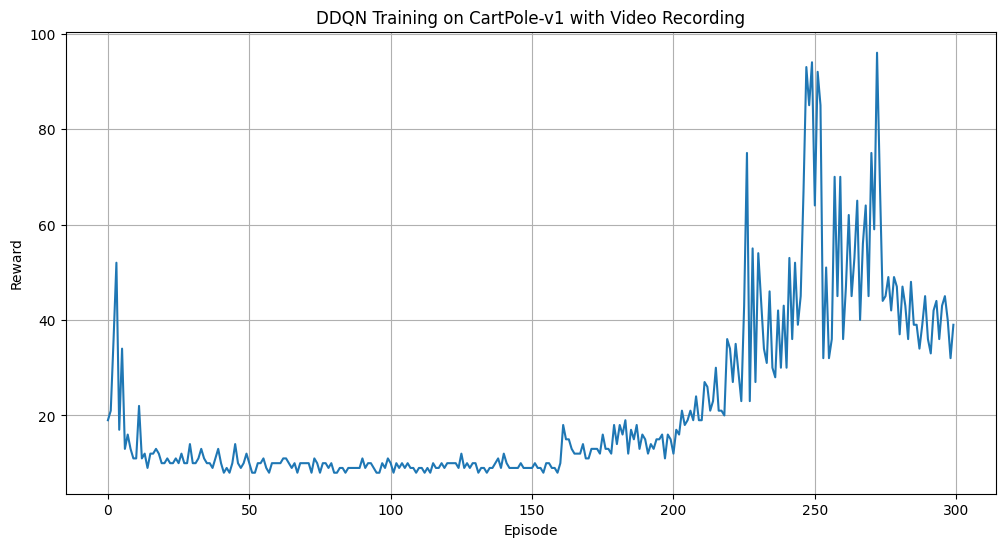

In [4]:
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
import matplotlib.pyplot as plt
from gym.wrappers import RecordVideo
import os
import base64
from IPython.display import HTML

# Создаем папку для сохранения видео
if not os.path.exists('videos'):
    os.makedirs('videos')

# Среда с записью видео (будет записывать каждые 50 эпизодов)
env = gym.make('CartPole-v1')
env = RecordVideo(env, 'videos', episode_trigger=lambda x: x % 50 == 0)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

# Hyperparameters
LR = 0.001
GAMMA = 0.99
BATCH_SIZE = 64
MEMORY_SIZE = 10000
UPDATE_TARGET_EVERY = 10
EPSILON_START = 1.0
EPSILON_END = 0.01
EPSILON_DECAY = 0.995
EPISODES = 300

# Нейросеть для Q-функции
class DQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# Агент DDQN
class DDQNAgent:
    def __init__(self):
        self.q_net = DQN(state_dim, action_dim)
        self.target_net = DQN(state_dim, action_dim)
        self.target_net.load_state_dict(self.q_net.state_dict())
        self.optimizer = optim.Adam(self.q_net.parameters(), lr=LR)
        self.memory = deque(maxlen=MEMORY_SIZE)
        self.epsilon = EPSILON_START
        self.update_target_counter = 0

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if random.random() < self.epsilon:
            return env.action_space.sample()
        state = torch.FloatTensor(state)
        with torch.no_grad():
            q_values = self.q_net(state)
        return torch.argmax(q_values).item()

    def train(self):
        if len(self.memory) < BATCH_SIZE:
            return

        batch = random.sample(self.memory, BATCH_SIZE)
        states = torch.FloatTensor([x[0] for x in batch])
        actions = torch.LongTensor([x[1] for x in batch])
        rewards = torch.FloatTensor([x[2] for x in batch])
        next_states = torch.FloatTensor([x[3] for x in batch])
        dones = torch.FloatTensor([x[4] for x in batch])

        # DDQN логика
        current_q = self.q_net(states).gather(1, actions.unsqueeze(1))

        with torch.no_grad():
            next_actions = torch.argmax(self.q_net(next_states), dim=1)
            next_q = self.target_net(next_states).gather(1, next_actions.unsqueeze(1))
            target_q = rewards + (1 - dones) * GAMMA * next_q

        loss = nn.MSELoss()(current_q, target_q)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Decay epsilon
        self.epsilon = max(EPSILON_END, self.epsilon * EPSILON_DECAY)

        # Обновляем целевую сеть
        self.update_target_counter += 1
        if self.update_target_counter % UPDATE_TARGET_EVERY == 0:
            self.target_net.load_state_dict(self.q_net.state_dict())

# Обучение
agent = DDQNAgent()
rewards_history = []

for episode in range(EPISODES):
    state = env.reset()
    total_reward = 0

    while True:
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        agent.remember(state, action, reward, next_state, done)
        agent.train()
        total_reward += reward
        state = next_state

        if done:
            break

    rewards_history.append(total_reward)
    print(f"Episode: {episode}, Reward: {total_reward}, Epsilon: {agent.epsilon:.2f}")

env.close()

# Визуализация результатов
plt.figure(figsize=(12, 6))
plt.plot(rewards_history)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('DDQN Training on CartPole-v1 with Video Recording')
plt.grid()
plt.show()

# Показываем последнее записанное видео
def show_video(video_path):
    video_files = [f for f in os.listdir(video_path) if f.endswith('.mp4')]
    if not video_files:
        print("No video files found")
        return

    latest_video = max(video_files, key=lambda x: os.path.getctime(os.path.join(video_path, x)))
    video_file = open(os.path.join(video_path, latest_video), 'rb').read()
    encoded = base64.b64encode(video_file).decode('utf-8')
    return HTML(f'''
        <video width="640" height="480" controls>
            <source src="data:video/mp4;base64,{encoded}" type="video/mp4">
        </video>
    ''')

show_video('videos')